In [7]:
import pandas as pd
from sklearn.metrics import r2_score
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

import tqdm

In [8]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

### Idea

Submissions are limited, thus we need a way to quickly screen if a prediction is usable as anomaly detector

**Given** Assumed ratio of anomalies R

* For each feature in group of features:
    * Predict feature based on remaining features
    * Classify everything in the R quantile and 1-R quantile as anomalies
    * Evaluate plausibility of anomaly detector (e.g., how coherent are the anomalies?)

### Plausibility
I assume plausibility to be reflected in the distribution of block-lengths of connected anomalies.
For example: A detector that produces mainly isolated one-point anomalies is nonsense.

## Model configuration and group of features to investigate:

In [83]:
train_df.head()

,id,Datum_Uhrzeit_CET,Demand,correction,correctedDemand,FRCE,controlBandPos,controlBandNeg,LFCInput,aFRRactivation,aFRRrequest,participationCMO,participationIN,correctionEcho,BandLimitedCorrectedDemand,controlArea
0,0,2022-10-23 00:00:04,-200.723,200.723,0.000,58.0890,127,-125.0,137.5740,-58.0890,-11.097600,1.0,1.0,249.719,0.0,2
1,1,2022-10-23 00:00:04,-656.771,134.514,-522.256,-265.9470,249,-167.0,-221.6890,-256.3040,-167.000000,1.0,1.0,185.760,-167.0,1
2,2,2022-10-23 00:00:08,-196.995,196.995,0.000,56.3801,127,-125.0,109.1030,-56.3800,0.261344,1.0,1.0,200.723,0.0,2
3,3,2022-10-23 00:00:08,-639.424,158.032,-481.392,-223.3750,249,-167.0,-219.0110,-258.0160,-167.000000,1.0,1.0,183.128,-167.0,1
4,4,2022-10-23 00:00:12,-206.247,206.247,0.000,53.3933,127,-125.0,47.8701,-53.3923,1.914730,1.0,1.0,196.995,0.0,2


In [80]:
hyperparameters = {"max_depth": 6}
regression_class = DecisionTreeRegressor
group = ["aFRRactivation", "aFRRrequest"]#"correction", "correctedDemand", "Demand"]

In [81]:
def train_intrafeature(train_data, val_data, group, regression_class, hyperparameters={}, metrics=[r2_score]):
    """
    Takes a group of features and trains regression for each feature, based on all remaining features. 
    Returns classifiers as dict.
    """
    for feature_name in group:
        assert feature_name in train_data.columns

    model_dict = {}
    for target_name in group:
        remaining_feature_names = [feature_name for feature_name in group if not feature_name == target_name]
        print(f"Training model: '{target_name}' from {remaining_feature_names} ")
        model = regression_class(**hyperparameters)
        train_subset = train_data[remaining_feature_names]
        val_subset = val_data[remaining_feature_names]
        train_target = train_data[target_name]
        val_target = val_data[target_name]
        model.fit(train_subset, train_target)
        train_pred = model.predict(train_subset)
        val_pred = model.predict(val_subset)
        for metric in metrics:
            train_score = metric(train_target, train_pred)
            val_score = metric(val_target, val_pred)
            print(f"\t{metric}")
            print(f"\t\ttrain:\t{train_score}")
            print(f"\t\tval:\t{val_score}")
        print("\t...done.")
        model_dict[target_name] = (model, remaining_feature_names)
    return model_dict

def run_intrafeature_model(data, model, target_name, remaining_feature_names):
    subset = data[remaining_feature_names]
    target = data[target_name]
    pred = model.predict(subset)
    return target, pred

def hypothesize_anomalies(target, prediction, quantile=0.15):
    residuals = target - prediction
    lower, upper = residuals.quantile(quantile), residuals.quantile(1 - quantile)
    anomalies = residuals.apply(lambda x: 0 if lower < x < upper else 1)
    return anomalies

def count_anomagrams(anomalies):
    """
    Determine counts of lengths of anomalous blocks
    """
    counts = []
    counter = 0
    for anomaly in anomalies:
        if anomaly == 1:
            counter += 1
        if anomaly == 0 and counter > 0:
            counts.append(counter)
            counter = 0
    return np.array(counts)

In [82]:
model_dict = train_intrafeature(train_df, 
                                test_df,
                                group=group, 
                                regression_class=regression_class, 
                                hyperparameters=hyperparameters,
                                metrics=[r2_score])

Training model: 'aFRRactivation' from ['aFRRrequest'] 
	<function r2_score at 0x7f51564c4c20>
		train:	0.5353755655813035
		val:	0.8808870215463835
	...done.
Training model: 'aFRRrequest' from ['aFRRactivation'] 
	<function r2_score at 0x7f51564c4c20>
		train:	0.07506995366639757
		val:	0.8804353433948094
	...done.


In [84]:
selector_control_area = train_df.controlArea == 2
target_name = "aFRRactivation"
model, remaining = model_dict[target_name]
target, pred = run_intrafeature_model(train_df, model, target_name, remaining)
anomalies = hypothesize_anomalies(target[selector_control_area], pred[selector_control_area], 0.15)

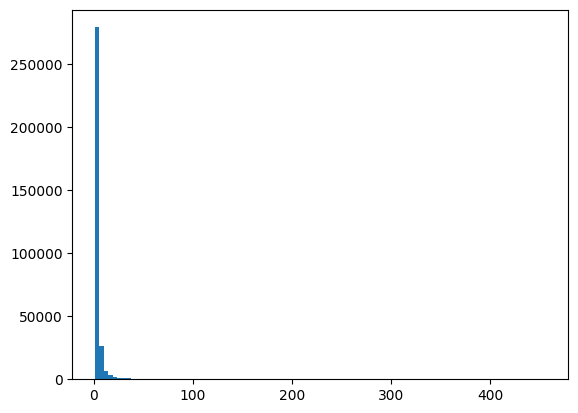

In [85]:
cutoff = 500
counts = count_anomagrams(anomalies)
counts = counts[counts < cutoff]
hist = plt.hist(counts, bins=100)
